# Imports

In [1]:
import os.path
os.chdir("set path to git repo here")

import pandas as pd
import numpy as np
import torch
import random

import sklearn
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

import scipy
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statistics import mean

# Environment to run this notebook


These are the versions of the core packages we use to run this notebook:

In [2]:
print("Tensorflow version: ",tf.__version__)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)

Tensorflow version:  2.9.1
Numpy version:  1.22.3
Pandas version:  2.0.3


# Methods

Adapt the path below to your needs to load your precomputed embeddings

In [2]:
def read():
    train = "./notebooks/embedding/example_data/GB1_embedded/train_ESM2_8M.pkl"
    valid = "./notebooks/embedding/example_data/GB1_embedded/valid_ESM2_8M.pkl"
    test =  "./notebooks/embedding/example_data/GB1_embedded/test_ESM2_8M.pkl"
    
    df_train=pd.read_pickle(train)
    df_valid=pd.read_pickle(valid)
    df_test=pd.read_pickle(test)
    
    return df_train, df_valid, df_test

Training methods

In [3]:
# create a predictor network
def emb_predictor(lr, dropout,dense,normalizer,epsilon,num_label=1):
    tf.keras.backend.clear_session()
    model = keras.Sequential([
      normalizer,

      layers.Dense(dense, activation='relu'),

      layers.Dropout(dropout),
      layers.Dense(num_label)
    ])
    if num_label == 1:
        model.compile(loss='mean_squared_error',
                    optimizer=tf.keras.optimizers.Adam(lr,epsilon=epsilon))
    else:
        model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer=tf.keras.optimizers.Adam(lr,epsilon=epsilon))        

    return model

def set_seed(s):
    tf.random.set_seed(s)
    np.random.seed(s)
    random.seed(s)
   
            
def train_predictor(epochs=240,lr=1e-4,epsilon=1e-07,batch=8,dropout=0.2,dense=32,seed=99,num_labels=1):

    set_seed(seed)    
   
    df_train, df_valid, df_test = read()    
    
    normalizer = keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(df_train.iloc[:, :-2]))
    
    model=emb_predictor(lr, dropout,dense,normalizer,epsilon,num_labels)
    model.summary()
    
    spearman = []
    
    class Spearman_Callback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            predictions=self.model.predict(df_valid.iloc[:, :-2])
            spearman.append(scipy.stats.spearmanr(a=np.array(df_valid.iloc[:, -1]), b=predictions).correlation)

    
    history = model.fit(
        np.array(df_train.iloc[:, :-2]),
        np.array(df_train.iloc[:, -1]),
        batch_size=batch,
        validation_data=[np.array(df_valid.iloc[:, :-2]),np.array(df_valid.iloc[:, -1])],
        epochs=epochs,
        callbacks = [Spearman_Callback()])
    
    return model, history, spearman


# GB1 - ESM2 8M example

## Train model

In [6]:
model, history, spearman = train_predictor(seed = 42)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 320)              641       
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                10272     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,946
Trainable params: 10,305
Non-trainable params: 641
_________________________________________________________________
Epoch 1/240
337/337 [==============================] - 1s 2ms/step - loss: 1.8983 - val_loss: 1.1897
Epoch 2/240
337

337/337 [==============================] - 1s 2ms/step - loss: 0.3801 - val_loss: 0.3948
Epoch 94/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3650 - val_loss: 0.3822
Epoch 95/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3662 - val_loss: 0.3810
Epoch 96/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3629 - val_loss: 0.3735
Epoch 97/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3601 - val_loss: 0.3852
Epoch 98/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3508 - val_loss: 0.3742
Epoch 99/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3693 - val_loss: 0.3718
Epoch 100/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3454 - val_loss: 0.3775
Epoch 101/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3568 - val_loss: 0.3855
Epoch 102/240
337/337 [==============================] - 1s 2ms/step - loss: 0.3515 - val_los

337/337 [==============================] - 1s 2ms/step - loss: 0.2562 - val_loss: 0.3187
Epoch 192/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2612 - val_loss: 0.3070
Epoch 193/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2699 - val_loss: 0.3020
Epoch 194/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2715 - val_loss: 0.2970
Epoch 195/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2614 - val_loss: 0.3029
Epoch 196/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2706 - val_loss: 0.2932
Epoch 197/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2616 - val_loss: 0.3149
Epoch 198/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2576 - val_loss: 0.2959
Epoch 199/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2596 - val_loss: 0.3002
Epoch 200/240
337/337 [==============================] - 1s 2ms/step - loss: 0.2637 - v

## Plot training history

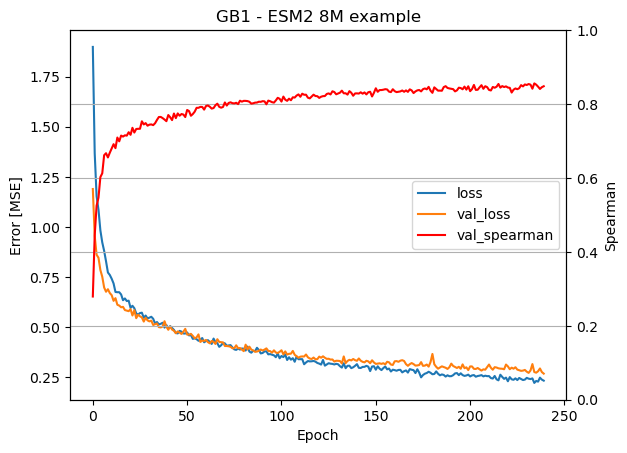

In [7]:
lns1=plt.plot(history.history['loss'], label='loss')
lns2=plt.plot(history.history['val_loss'], label='val_loss')

plt.xlabel('Epoch')
plt.ylabel('Error [MSE]')

lns3=plt.gca().twinx().plot(spearman, label='val_spearman' ,color = 'r')
plt.ylim([0, 1])
plt.ylabel('Spearman')

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]    
plt.legend(lns, labs,loc='center right')

plt.title("GB1 - ESM2 8M example")
plt.grid(True)

## Predict on Test set

In [8]:
test =  "./notebooks/embedding/example_data/GB1_embedded/test_ESM2_8M.pkl"

df_test=pd.read_pickle(test)

predictions=model.predict(df_test.iloc[:, :-2])
print("Test spearman:", scipy.stats.spearmanr(a=np.array(df_test.iloc[:, -1]), b=predictions).correlation)


180/180 [==============================] - 0s 718us/step
Test spearman: 0.8189302775933469
